In [17]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import librosa
from matplotlib import pyplot as plt
import glob

In [3]:
def load_wav_16k_mono(filename):
    # Convert TensorFlow string tensor to a Python string
    filename = filename.numpy().decode("utf-8")  

    # Load audio using librosa (forces single-channel audio, resamples to 16kHz)
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)

    # Convert numpy array to tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    
    return wav

In [9]:
wd = os.getcwd().replace("/_scripts","")

Current Working Directory: /Users/ec/Documents/Data/Frog-Call-Classifier/_scripts
Folders and files in this directory:
['venv_creation', 'AudioClassification.ipynb', 'Example_AudioClassification.ipynb']


In [11]:
POS = os.path.join(wd,'_data','Example', 'Parsed_Capuchinbird_Clips', '*.wav')
NEG = os.path.join(wd,'_data','Example','Parsed_Not_Capuchinbird_Clips', '*.wav')

# Load file paths
pos_files = tf.data.Dataset.list_files(POS)
neg_files = tf.data.Dataset.list_files(NEG)

# Check if files are loaded
print(f"Positive samples: {len(list(pos_files))}")
print(f"Negative samples: {len(list(neg_files))}")

Positive samples: 217
Negative samples: 593


2025-02-18 16:18:03.332757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-18 16:18:03.347165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
files = glob.glob(POS)

if files:
    print(f"Found {len(files)} files in POS.")
    print(files[:5])  # Print first 5 files for inspection
else:
    print("No files found in POS.")

Found 217 files in POS.
['/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC388470-3.wav', '/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC22397-2.wav', '/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC27881-0.wav', '/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC227469-0.wav', '/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC201990-1.wav']


In [14]:
def preprocess(file_path, label):
    # Wrap librosa function inside tf.py_function()
    wav = tf.py_function(load_wav_16k_mono, [file_path], tf.float32)

    # Ensure shape is known after calling py_function
    wav.set_shape([None])

    # Clip or pad audio to 3 seconds (48,000 samples at 16kHz)
    wav = wav[:48000]  
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], axis=0)

    return wav, label

In [15]:
# Apply preprocessing to datasets
positives = pos_files.map(lambda x: preprocess(x, 1))
negatives = neg_files.map(lambda x: preprocess(x, 0))

# Combine both datasets
data = positives.concatenate(negatives)

# Shuffle and batch dataset
data = data.cache().shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

In [18]:
for sample_wav, sample_label in data.take(1):
    print("Waveform shape:", sample_wav.shape)
    print("Label shape:", sample_label.shape)
    print("Label values:", sample_label.numpy())


Waveform shape: (16, 48000)
Label shape: (16,)
Label values: [1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]


2025-02-18 16:19:02.923937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


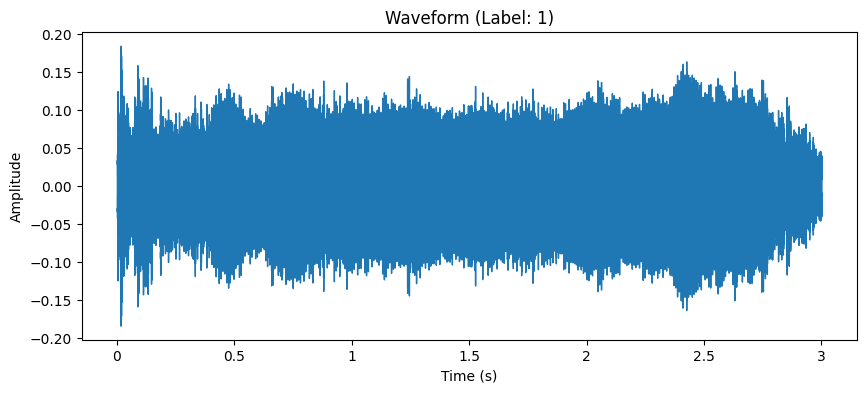

In [21]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import IPython.display as ipd  # For playing audio in Jupyter Notebook

# Fetch one example from the dataset
for sample_wav, sample_label in data.take(1):
    wav_numpy = sample_wav.numpy()[1]  # Convert first sample in batch to numpy
    label = sample_label.numpy()[1]
    break

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(wav_numpy, sr=16000)
plt.title(f"Waveform (Label: {label})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the audio
ipd.Audio(wav_numpy, rate=16000)


2025-02-18 16:21:04.895915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


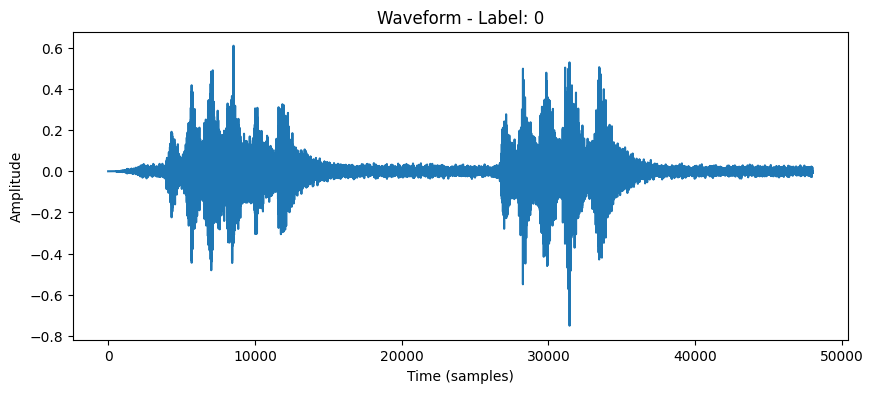

In [34]:
import matplotlib.pyplot as plt

# Extract one sample
for sample in data.take(1):
    audio, label = sample

# Convert to numpy for visualization
audio_sample = audio.numpy()[0]  # Take the first sample
plt.figure(figsize=(10, 4))
plt.plot(audio_sample)
plt.title(f"Waveform - Label: {label.numpy()[0]}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


2025-02-18 16:21:19.496569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


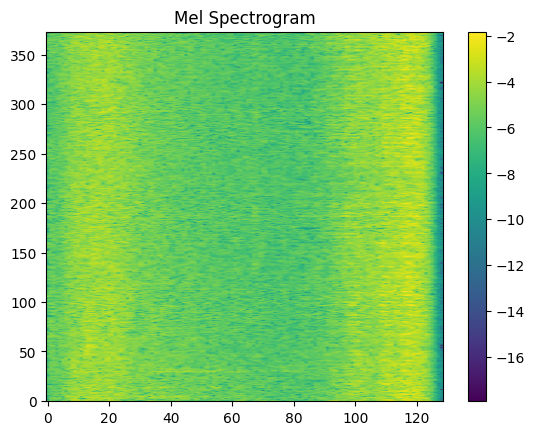

In [35]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

# Test it on one sample
for sample in data.take(1):
    audio, label = sample
    spectrogram = get_spectrogram(audio[0])  # Convert first sample

plt.imshow(tf.math.log(spectrogram).numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

In [60]:
import librosa
import numpy as np

first_file_path = next(iter(pos_files.as_numpy_iterator())).decode("utf-8")

# Load an example audio file
wav, sr = librosa.load(first_file_path, sr=16000)
mel_spec = librosa.feature.melspectrogram(y=wav, sr=sr)

# Check spectrogram shape
print(mel_spec.shape)  # Example: (128, 344)

# Use this shape (add a channel dimension)
input_shape = (128, 110, 1)

(128, 110)


In [48]:
from tensorflow.keras import layers, models

# Define model with a fixed input shape
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Define fixed input shape
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 342, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 171, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 169, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 161280)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    10,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,340,865 (39.45 MB)

 Trainable params: 10,340,865 (39.45 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(data, epochs=10)


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None), dtype=float32). Expected shape (None, 128, 344, 1), but input has incompatible shape (None, None)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None), dtype=float32)
  • training=True
  • mask=None

In [4]:
AudioClassifier = mp.tasks.audio.AudioClassifier
AudioClassifierOptions = mp.tasks.audio.AudioClassifierOptions
BaseOptions = mp.tasks.BaseOptions
AudioRunningMode = mp.tasks.audio.RunningMode

# Path to the pre-trained model
model_path = 'path/to/your/model.tflite'

options = AudioClassifierOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=AudioRunningMode.AUDIO_CLIPS,
    max_results=5
)

classifier = AudioClassifier.create_from_options(options)

I0000 00:00:1739908045.756938  369922 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Max


RuntimeError: Unable to open file at /Users/ec/Documents/Data/Frog-Call-Classifier/path/to/your/model.tflite

In [ ]:
def classify_audio(file_path):
    audio_data = create_audio_data(file_path)
    result = classifier.classify(audio_data)
    return result

# Example usage
file_path = 'path/to/your/audio.wav'
classification_result = classify_audio(file_path)
print(classification_result)
